# NSL-KDD - Introduction

The NSL-KDD dataset provides network connection records that include fundamental TCP/IP attributes, content-based indicators, and traffic-level statistics. In the given data sources, we work with two variants: one offering binary labels (normal vs. attack) and another providing detailed attack categories. Both versions share identical features and values, differing solely in their respective label columns.
Our strategy is to merge these datasets to obtain a unified and comprehensive view, enabling more robust and insightful conclusions.
In addition, the data is already split into training and test sets. We consolidate these splits as well and leave the task of defining the final split configuration to the AI developer.


## Exploratory Data Analysis

In this notebook, we will explore the dataset in depth. This includes examining the distributions of individual features, identifying correlations, and analyzing other statistical characteristics. Key observations, explanations, and interpretations will be provided where appropriate.

In [16]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Own modules
from dataprepper import DataPrepper

First, we import the binary classification dataset and the detailed classification dataset separately. After loading them, we verify that both have identical dimensions and ensure that their feature values are fully consistent with each other. This validation step is essential before combining the datasets into a unified representation.

In [17]:
# Import all datasets
d1_binary = pd.read_csv('../../../data/NSL-KDD/binary/KDDTest-21-binary.arff.csv')
d2_binary = pd.read_csv('../../../data/NSL-KDD/binary/KDDTest-binary.arff.csv')
d3_binary = pd.read_csv('../../../data/NSL-KDD/binary/KDDTrain-20P-binary.arff.csv')
d4_binary = pd.read_csv('../../../data/NSL-KDD/binary/KDDTrain-binary.arff.csv')

d1_multi = pd.read_csv('../../../data/NSL-KDD/multi/KDDTest-21.csv')
d2_multi = pd.read_csv('../../../data/NSL-KDD/multi/KDDTest.csv')
d3_multi = pd.read_csv('../../../data/NSL-KDD/multi/KDDTrain-20P.csv')
d4_multi = pd.read_csv('../../../data/NSL-KDD/multi/KDDTrain.csv')


In [18]:
# check data dimensions
dataframes_multi = [d1_multi, d2_multi, d3_multi, d4_multi]
dataframes_binary = [d1_binary, d2_binary, d3_binary, d4_binary]
print('=== Data dimensions: ===')
for i, data in enumerate(dataframes_multi, start = 1):
  rows, cols = data.shape
  print(f'd{i}_multi -> {rows} rows, {cols} columns')

print("\n")

for i, data in enumerate(dataframes_binary, start = 1):
  rows, cols = data.shape
  print(f'd{i}_binary -> {rows} rows, {cols} columns')

=== Data dimensions: ===
d1_multi -> 11850 rows, 44 columns
d2_multi -> 22544 rows, 44 columns
d3_multi -> 25192 rows, 44 columns
d4_multi -> 125973 rows, 44 columns


d1_binary -> 11850 rows, 42 columns
d2_binary -> 22544 rows, 42 columns
d3_binary -> 25192 rows, 42 columns
d4_binary -> 125973 rows, 42 columns


In [19]:
# check if all datasets have the same columns
mark = True
ref = list(dataframes_multi[0].columns)
for df in dataframes_multi[1:]:
    if list(df.columns) != ref:
        mark = False
        break
print(f'All multi datasets have the same columns: {mark}')

mark = True
ref = list(dataframes_binary[0].columns)
for df in dataframes_binary[1:]:
    if list(df.columns) != ref:
        mark = False
        break
print(f'All binary datasets have the same columns: {mark}')


All multi datasets have the same columns: True
All binary datasets have the same columns: True


Now we need to examine the differences between the two datasets to determine how they diverge and how they can be aligned.

In [20]:
cols_multi = [set(df.columns) for df in dataframes_multi]
cols_binary = [set(df.columns) for df in dataframes_binary]

# Common columns within each class
common1 = set.intersection(*cols_multi)
common2 = set.intersection(*cols_binary)

# Equality within each class
same_cols_1 = all(cols_multi[0] == c for c in cols_multi)
same_cols_2 = all(cols_binary[0] == c for c in cols_binary)

# All columns across both classes
all_cols = set.union(*cols_multi, *cols_binary)

# Different columns between classes
diff = (common1 ^ common2)

# Mapping of columns to dataframes
mapping = {}
for col in diff:
    mapping[col] = {
        "multi": [i for i, df in enumerate(dataframes_multi) if col in df.columns],
        "binary": [i for i, df in enumerate(dataframes_binary) if col in df.columns]
    }

print("multi common columns:", common1)
print("binary common columns:", common2)
print("\n")
print("Equality within multi:", same_cols_1)
print("Equality within binary:", same_cols_2)
print("\n")
print("Different columns between classes:", diff)
print("\n")
print("\nMapping (column -> in which DataFrames present):")
for col, info in mapping.items():
    print(f"{col}: {info}")


multi common columns: {'srv_serror_rate', 'root_shell', 'dst_host_same_srv_rate', 'urgent', 'dst_host_same_src_port_rate', 'serror_rate', 'is_guest_login', 'land', 'duration', 'dst_host_serror_rate', 'src_bytes', 'dst_host_rerror_rate', 'num_root', 'num_file_creations', 'difficulty', 'dst_bytes', 'num_shells', 'attack_category', 'flag', 'srv_rerror_rate', 'num_access_files', 'srv_diff_host_rate', 'dst_host_srv_diff_host_rate', 'dst_host_srv_rerror_rate', 'same_srv_rate', 'logged_in', 'su_attempted', 'protocol_type', 'is_host_login', 'num_compromised', 'hot', 'dst_host_count', 'dst_host_diff_srv_rate', 'num_outbound_cmds', 'srv_count', 'service', 'diff_srv_rate', 'attack_label', 'count', 'rerror_rate', 'dst_host_srv_count', 'num_failed_logins', 'wrong_fragment', 'dst_host_srv_serror_rate'}
binary common columns: {'srv_serror_rate', 'root_shell', 'dst_host_same_srv_rate', 'urgent', 'dst_host_same_src_port_rate', 'serror_rate', 'is_guest_login', 'land', 'duration', 'dst_host_serror_rate',

Since the binary dataset contains the same columns as the detailed one - except for a single additional label column - we use the detailed dataset as our reference. The missing column, class, simply indicates whether a packet is normal or represents an attack attempt.
We can reconstruct this information directly from the attack_category column of the detailed dataset: if the category is normal, we assign the label 0; otherwise, we assign 1.
This new boolean column, named anomaly_bool, allows us to replicate the binary classification within the detailed dataset and serves as a consistent basis for combining both datasets.

In [21]:
concatenated_df = pd.concat(dataframes_multi, ignore_index=True)
multi_dp = DataPrepper(df=concatenated_df, target_col=['attack_category', 'attack_label'], name="Concatenated NSL-KDD Multi Dataset")
multi_dp.inspect()


=== Concatenated NSL-KDD Multi Dataset: SHAPE ===
(185559, 44)

=== Concatenated NSL-KDD Multi Dataset: HEAD ===
   duration protocol_type  service flag  src_bytes  dst_bytes  land  \
0        13           tcp   telnet   SF        118       2425     0   
1         0           udp  private   SF         44          0     0   
2         0           tcp   telnet   S3          0         44     0   
3         0           udp  private   SF         53         55     0   
4         0           tcp  private   SH          0          0     0   

   wrong_fragment  urgent  hot  ...  dst_host_diff_srv_rate  \
0               0       0    0  ...                    0.12   
1               0       0    0  ...                    0.01   
2               0       0    0  ...                    0.61   
3               0       0    0  ...                    0.00   
4               0       0    0  ...                    1.00   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                

,count,mean,std,min,25%,50%,75%,max
duration,185559.0,289.472982,2.462219e+03,0.0,0.00,0.00,0.00,5.771500e+04
src_bytes,185559.0,36743.194138,4.923242e+06,0.0,0.00,44.00,276.00,1.379964e+09
dst_bytes,185559.0,14230.001940,3.313482e+06,0.0,0.00,0.00,480.00,1.309937e+09
land,185559.0,0.000221,1.486292e-02,0.0,0.00,0.00,0.00,1.000000e+00
wrong_fragment,185559.0,0.020673,2.403877e-01,0.0,0.00,0.00,0.00,3.000000e+00
urgent,185559.0,0.000253,2.165160e-02,0.0,0.00,0.00,0.00,3.000000e+00
hot,185559.0,0.190608,1.992283e+00,0.0,0.00,0.00,0.00,1.010000e+02
num_failed_logins,185559.0,0.006251,8.506629e-02,0.0,0.00,0.00,0.00,5.000000e+00
logged_in,185559.0,0.392139,4.882288e-01,0.0,0.00,0.00,1.00,1.000000e+00
num_compromised,185559.0,0.249619,2.041382e+01,0.0,0.00,0.00,0.00,7.479000e+03


Now that the base dataset is prepared, we address extreme values before examining structural patterns.
We begin with missing data: the only column containing NaN values is attack_category. Since this feature is a potential target variable, imputing it would introduce unnecessary bias and uncertainty. With only about 4% of the records affected, the most reliable approach is to remove all rows containing a NaN in this column. This ensures data integrity without significantly reducing the dataset’s size.

In [22]:
_ = multi_dp.missing_kill(col='attack_category')

Removed 7490 rows containing NaN values in "attack_category" (178069 remain).


As previously outlined, we now append the class column from the binary classification dataset to the final dataset.
This step aligns both label types - binary and detailed - within a single unified structure, enabling more flexible analyses and comparisons.

In [23]:
multi_dp.df["anomaly_bool"] = multi_dp.df["attack_category"].apply(
    lambda x: 0 if x == "normal" else 1
)

With the final dataset prepared, we create a general `DataPrepper` instance and run all inspection functions on it.

In [24]:
# Clean up memory
for dm in dataframes_multi: del dm
for db in dataframes_binary: del db
del concatenated_df


data = DataPrepper(df=multi_dp.df, 
                   target_col=['attack_category', 'attack_label', 'anomaly_bool'], 
                   name="NSL-KDD Combined Dataset"
                   )
del multi_dp

data.inspect()



=== NSL-KDD Combined Dataset: SHAPE ===
(178069, 45)

=== NSL-KDD Combined Dataset: HEAD ===
   duration protocol_type  service flag  src_bytes  dst_bytes  land  \
0        13           tcp   telnet   SF        118       2425     0   
3         0           udp  private   SF         53         55     0   
4         0           tcp  private   SH          0          0     0   
5         0           tcp     http   SF      54540       8314     0   
6         0           tcp    imap4  REJ          0          0     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_src_port_rate  \
0               0       0    0  ...                         0.04   
3               0       0    0  ...                         0.87   
4               0       0    0  ...                         1.00   
5               0       0    2  ...                         0.00   
6               0       0    0  ...                         0.00   

   dst_host_srv_diff_host_rate  dst_host_serror_rate  \
0             

,count,mean,std,min,25%,50%,75%,max
duration,178069.0,253.793602,2.446030e+03,0.0,0.00,0.00,0.00,5.445100e+04
src_bytes,178069.0,36868.617603,5.020186e+06,0.0,0.00,44.00,277.00,1.379964e+09
dst_bytes,178069.0,14809.588255,3.382449e+06,0.0,0.00,0.00,561.00,1.309937e+09
land,178069.0,0.000230,1.517221e-02,0.0,0.00,0.00,0.00,1.000000e+00
wrong_fragment,178069.0,0.021542,2.453531e-01,0.0,0.00,0.00,0.00,3.000000e+00
urgent,178069.0,0.000129,1.624584e-02,0.0,0.00,0.00,0.00,3.000000e+00
hot,178069.0,0.198120,2.033103e+00,0.0,0.00,0.00,0.00,1.010000e+02
num_failed_logins,178069.0,0.006436,8.546397e-02,0.0,0.00,0.00,0.00,5.000000e+00
logged_in,178069.0,0.397874,4.894605e-01,0.0,0.00,0.00,1.00,1.000000e+00
num_compromised,178069.0,0.257041,2.083089e+01,0.0,0.00,0.00,0.00,7.479000e+03


In [25]:
# Drop duplicates (no additional info lost)
data.df.drop_duplicates(inplace = True)

In this context, several encoding strategies can be considered for representing the attack categories:

- LabelEncoder
- OneHotEncoder
- OrdinalEncoder

OrdinalEncoder can be excluded immediately, as the attack types have no inherent order.
OneHotEncoder is also unsuitable: three columns contain more than ten unique values, which would lead to a large and unnecessary increase in dimensionality. The remaining categorical features include a target column and, for consistency, we also avoid one-hot encoding for the final one.

To prevent this overhead, we apply LabelEncoder. It is important to note that the resulting numeric assignments carry no ordinal meaning - they are purely symbolic identifiers for the distinct classes.

In [ ]:
'''
Non -numeric columns to encode:
 1   protocol_type                178069 non-null  object | count: 3
 2   service                      178069 non-null  object | count: 70
 3   flag                         178069 non-null  object | count: 11
 41  attack_label                 178069 non-null  object | count: 23
 43  attack_category              178069 non-null  object | count: 5
'''

# in order to inspect correlation: make all categorical variables numeric (no order)
_ = data.apply_labelEncoding(col='protocol_type')
_ = data.apply_labelEncoding(col='service')
_ = data.apply_labelEncoding(col='flag')
_ = data.apply_labelEncoding(col='attack_label')
# _ = data.apply_labelEncoding(col='attack_category')


le = LabelEncoder()
data.df['attack_number'] = le.fit_transform(data.df['attack_category'])


# Display mapping of encoded values for the preferred target column
encoded_values = data.df['attack_number'].unique()
for val in sorted(encoded_values):
    print(f"{val}: {le.inverse_transform([val])[0]}")

Applied Label-Encoding on 'protocol_type' (3 unique classes)
Applied Label-Encoding on 'service' (70 unique classes)
Applied Label-Encoding on 'flag' (11 unique classes)
Applied Label-Encoding on 'attack_label' (23 unique classes)
0: dos
1: normal
2: probe
3: r2l
4: u2r


In [27]:
# Inspect target variable distribution
for col in data.target_col:
    print(f"Unique values in target column '{col}': {data.df[col].unique()}")
    print(f"Value counts in target column '{col}':")
    print(data.df[col].value_counts())
    print("----------------------------------------------------------")

Unique values in target column 'attack_category': ['r2l' 'normal' 'probe' 'dos' 'u2r']
Value counts in target column 'attack_category':
attack_category
normal    76967
dos       51268
probe     12639
r2l        3194
u2r          89
Name: count, dtype: int64
----------------------------------------------------------
Unique values in target column 'attack_label': [ 3 11 10  0  9 17 22  5 18 20 15  8  6  1 14 16  2  7 13 12  4 21 19]
Value counts in target column 'attack_label':
attack_label
11    76967
9     45716
17     4360
5      3643
18     3108
15     3070
10     1566
0      1300
3      1284
22      964
20      901
21      890
14      221
1        50
8        25
16       23
6        22
4        12
2        11
7        11
13        6
12        5
19        2
Name: count, dtype: int64
----------------------------------------------------------
Unique values in target column 'anomaly_bool': [1 0]
Value counts in target column 'anomaly_bool':
anomaly_bool
0    76967
1    67190
Name: count

The detailed attack_labels are already mapped to more general attack_category. So we will not introduce an explicit mapping in this case and just use attack_category as is.

In [28]:
indent = '{:<3} {:<30}: {}'
print(' === Unique value counts === ')
for i, feature in enumerate(list(data.df.columns), start = 1):
    print(indent.format(f'{i}.', feature, data.df[feature].nunique()))


 === Unique value counts === 
1.  duration                      : 3027
2.  protocol_type                 : 3
3.  service                       : 70
4.  flag                          : 11
5.  src_bytes                     : 3505
6.  dst_bytes                     : 10379
7.  land                          : 2
8.  wrong_fragment                : 3
9.  urgent                        : 4
10. hot                           : 29
11. num_failed_logins             : 6
12. logged_in                     : 2
13. num_compromised               : 94
14. root_shell                    : 2
15. su_attempted                  : 3
16. num_root                      : 89
17. num_file_creations            : 36
18. num_shells                    : 4
19. num_access_files              : 10
20. num_outbound_cmds             : 1
21. is_host_login                 : 2
22. is_guest_login                : 2
23. count                         : 512
24. srv_count                     : 512
25. serror_rate                   : 9

In [29]:
# Inspect correlation over all features
data.inspect_correlation(annotate=True, big_dataset=True)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_label,difficulty,anomaly_bool,attack_number
duration,1.00,0.04,0.09,-0.06,0.07,0.03,-0.00,-0.01,0.00,0.00,0.00,-0.06,0.04,0.05,0.09,0.05,0.08,-0.00,0.07,nan,-0.00,0.00,-0.07,-0.04,-0.06,-0.06,0.18,0.18,0.07,-0.01,-0.04,0.04,-0.11,-0.11,0.23,0.21,-0.02,-0.06,-0.06,0.15,0.17,0.12,-0.13,0.04,0.14
protocol_type,0.04,1.00,0.04,0.10,-0.00,-0.00,-0.00,0.16,-0.00,-0.01,-0.01,-0.11,-0.00,-0.01,-0.00,-0.00,-0.00,-0.00,-0.01,nan,-0.00,-0.02,-0.04,0.06,-0.08,-0.08,-0.05,-0.05,0.04,0.04,-0.22,0.23,0.10,0.01,0.13,-0.18,-0.34,-0.08,-0.08,-0.03,-0.05,0.11,0.04,-0.28,0.05
service,0.09,0.04,1.00,-0.32,-0.00,0.00,-0.01,0.08,0.01,-0.06,0.08,-0.16,0.02,0.04,0.04,0.02,0.03,0.01,0.03,nan,-0.00,-0.09,0.12,-0.23,0.26,0.26,0.18,0.18,-0.38,0.21,-0.09,0.20,-0.40,-0.45,0.28,-0.10,-0.16,0.27,0.26,0.18,0.18,-0.05,0.01,0.29,-0.14
flag,-0.06,0.10,-0.32,1.00,-0.01,-0.00,-0.01,0.06,0.01,0.07,0.02,0.59,0.01,0.02,0.01,0.01,0.01,0.01,0.03,nan,0.00,0.08,-0.48,0.19,-0.42,-0.41,-0.77,-0.77,0.74,-0.29,0.21,-0.33,0.59,0.65,-0.27,0.20,0.08,-0.41,-0.41,-0.71,-0.75,0.16,0.01,-0.64,0.42
src_bytes,0.07,-0.00,-0.00,-0.01,1.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,nan,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.01,0.01,0.00,-0.00,-0.00,-0.01,-0.01,-0.01,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.01,0.01,-0.02,0.01,0.01
dst_bytes,0.03,-0.00,0.00,-0.00,0.00,1.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,nan,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.01,0.01,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.01,0.01,-0.00,-0.00,-0.00,0.01,0.01,0.01,-0.02,0.00,0.01
land,-0.00,-0.00,-0.01,-0.01,-0.00,-0.00,1.00,-0.00,-0.00,-0.00,-0.00,-0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,nan,-0.00,-0.00,-0.01,-0.00,0.02,0.02,-0.00,-0.01,0.01,-0.00,0.04,-0.02,-0.01,0.01,-0.00,0.03,0.07,0.02,0.01,-0.01,-0.01,-0.02,-0.03,0.01,-0.01
wrong_fragment,-0.01,0.16,0.08,0.06,-0.00,-0.00,-0.00,1.00,-0.00,-0.01,-0.01,-0.07,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,nan,-0.00,-0.01,-0.02,0.02,-0.04,-0.05,-0.03,-0.03,0.05,-0.03,-0.02,0.03,-0.05,-0.05,0.05,0.04,-0.01,-0.05,-0.05,0.02,-0.03,0.26,-0.15,0.09,-0.09
urgent,0.00,-0.00,0.01,0.01,-0.00,0.00,-0.00,-0.00,1.00,0.00,0.05,0.01,0.03,0.09,0.08,0.04,0.02,-0.00,0.01,nan,-0.00,-0.00,-0.01,-0.00,-0.00,-0.00,-0.00,-0.00,0.01,-0.00,-0.00,-0.01,-0.01,-0.01,0.01,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.02,-0.00,0.02
hot,0.00,-0.01,-0.06,0.07,0.00,-0.00,-0.00,-0.01,0.00,1.00,0.00,0.11,0.00,0.02,0.00,0.00,0.09,0.01,0.00,nan,0.00,0.72,-0.07,-0.03,-0.06,-0.06,-0.03,-0.03,0.07,-0.02,-0.03,-0.01,-0.05,-0.04,-0.01,-0.03,-0.02,-0.05,-0.05,-0.03,-0.03,0.09,-0.15,-0.01,0.11


In [30]:
# Inspect feature importance with respect to target variable (to determine relevant features)
adj_inspection = data.target_col.copy()
adj_inspection.remove('attack_category')
adj_inspection += ['attack_number']
for col in adj_inspection:
    print(f"Feature importance with respect to target column '{col}':")
    _ = data.inspect_filter_features(target_col=col)


Feature importance with respect to target column 'attack_label':

=== Positive correlation with 'attack_label' ===

1.  attack_number            :0.331
2.  dst_host_diff_srv_rate   :0.297
3.  srv_count                :0.273
4.  wrong_fragment           :0.257
5.  dst_host_same_src_port_rate :0.235
6.  diff_srv_rate            :0.231
7.  same_srv_rate            :0.223
8.  is_guest_login           :0.182
9.  flag                     :0.163
10. duration                 :0.117
11. protocol_type            :0.106
12. dst_host_srv_count       :0.089
13. hot                      :0.088
14. logged_in                :0.073
15. dst_host_rerror_rate     :0.073
16. count                    :0.070
17. dst_host_srv_rerror_rate :0.063
18. dst_host_same_srv_rate   :0.057
19. rerror_rate              :0.056
20. srv_rerror_rate          :0.055
21. dst_host_count           :0.011
22. src_bytes                :0.010
23. dst_bytes                :0.007
24. is_host_login            :0.005
25. su_attempted 

From the results we can conclude that all features with zero variance provide no useful information and can therefore be removed without loss. In addition, this output represents the key information on which features should be used during the model training as they are most important.

In [31]:
# Drop features with unique values only (zero variance and therefore no info)
_ = data.drop_uniques()

Dropped columns: ['num_outbound_cmds']


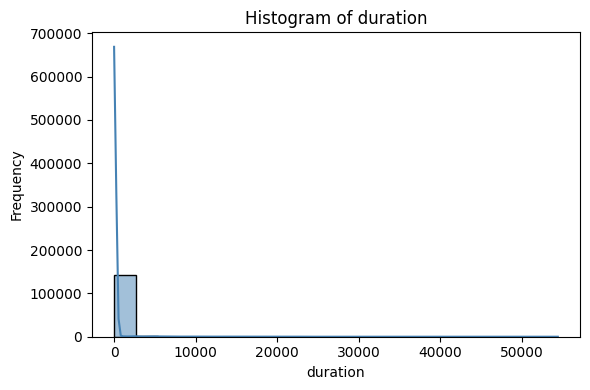

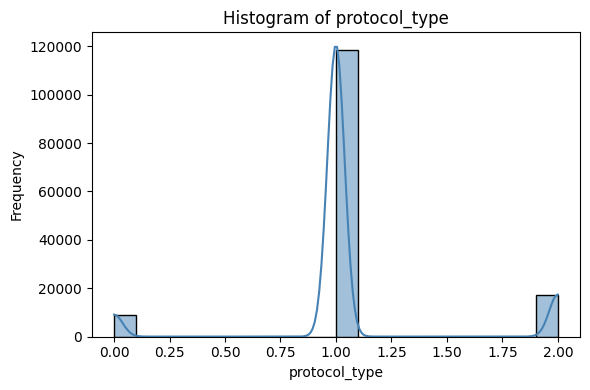

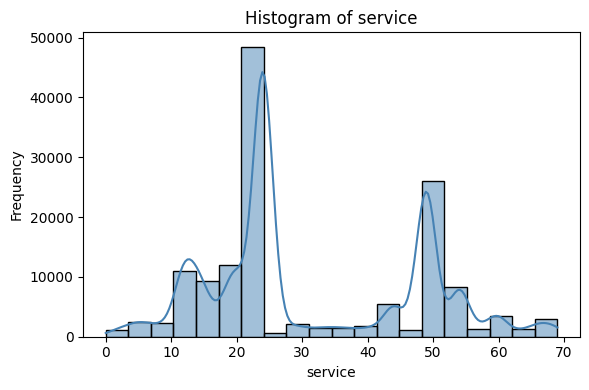

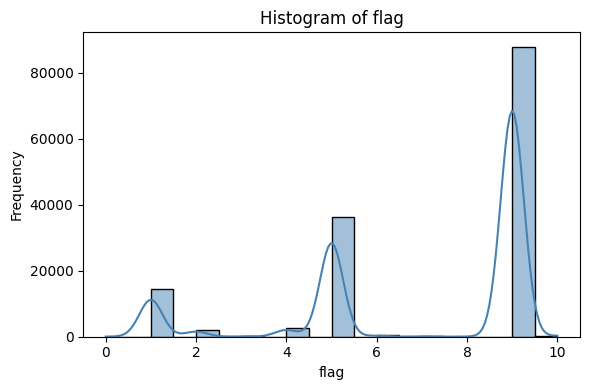

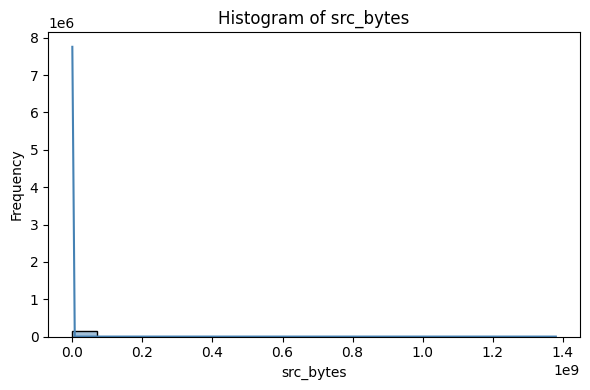

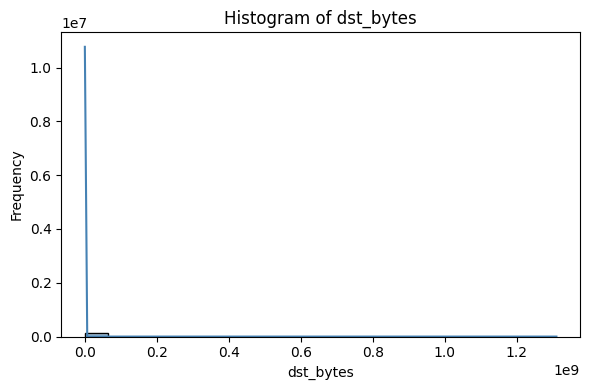

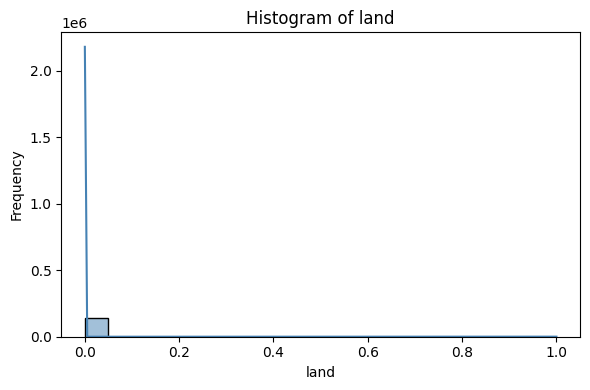

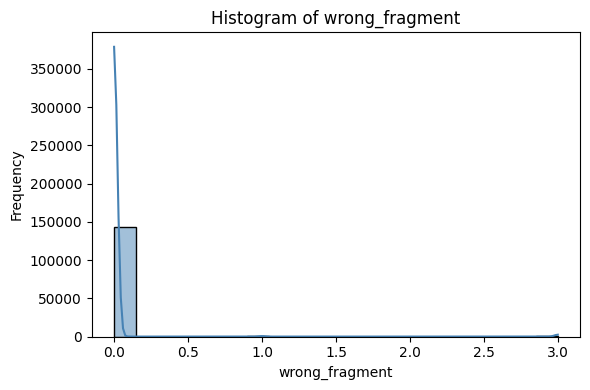

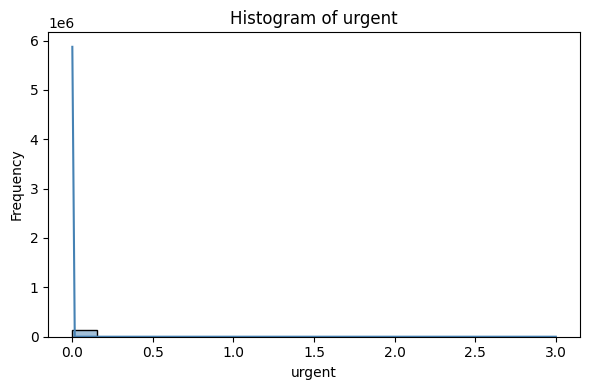

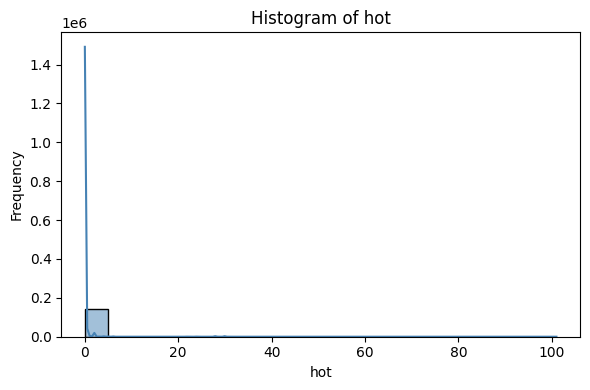

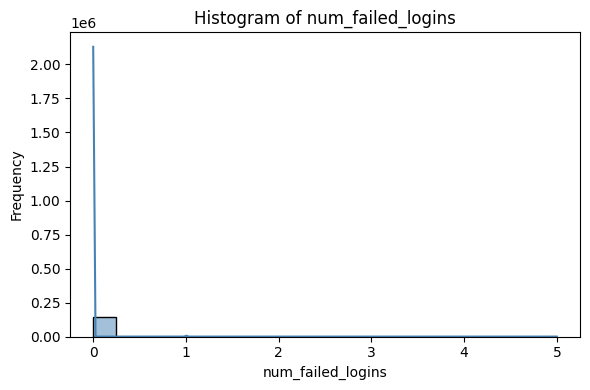

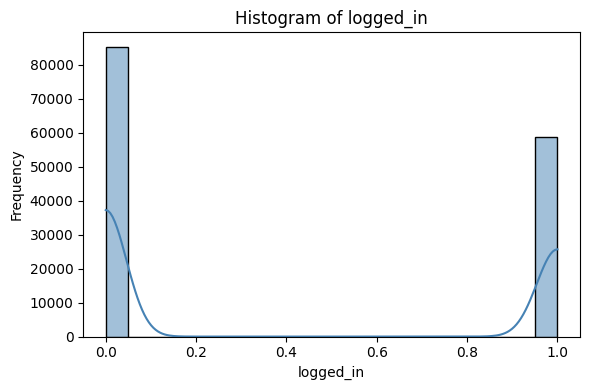

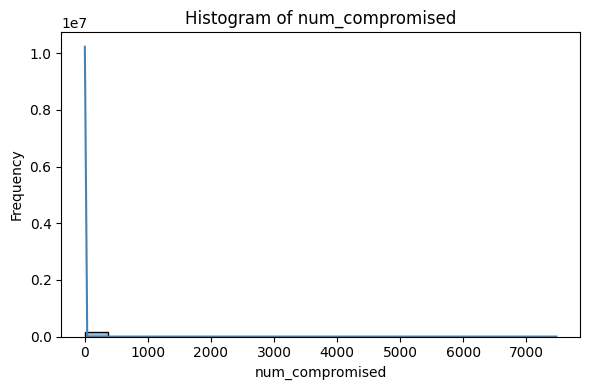

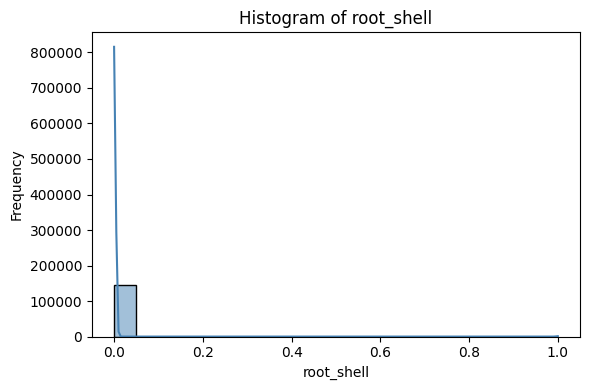

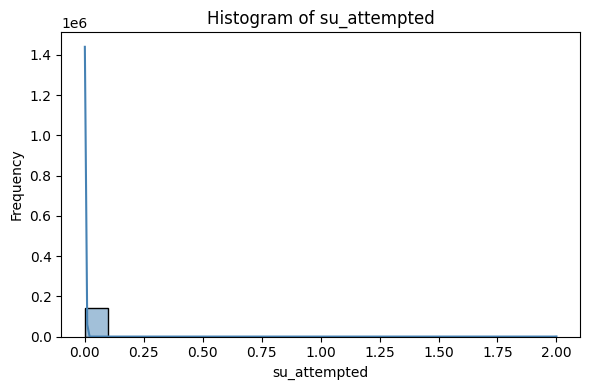

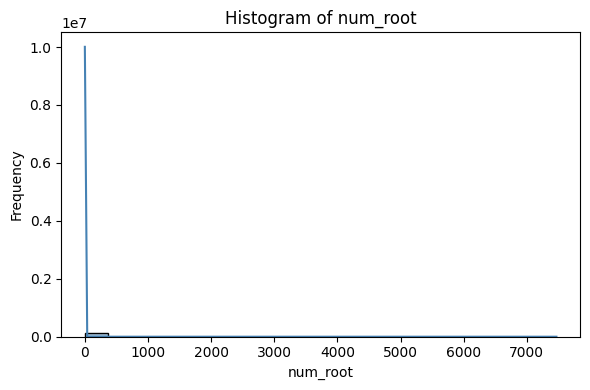

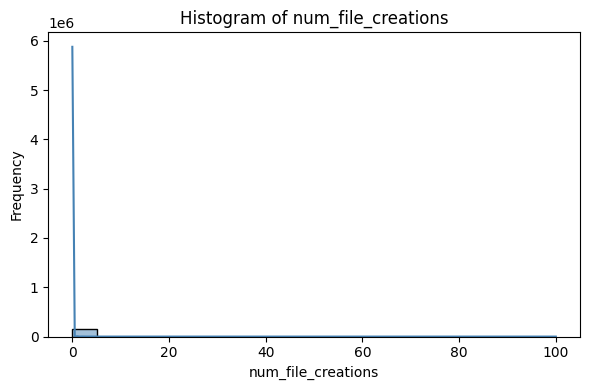

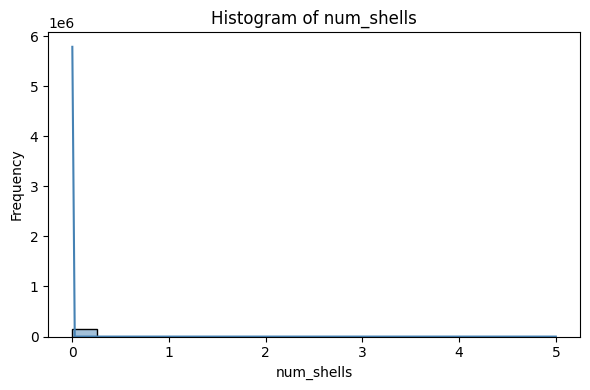

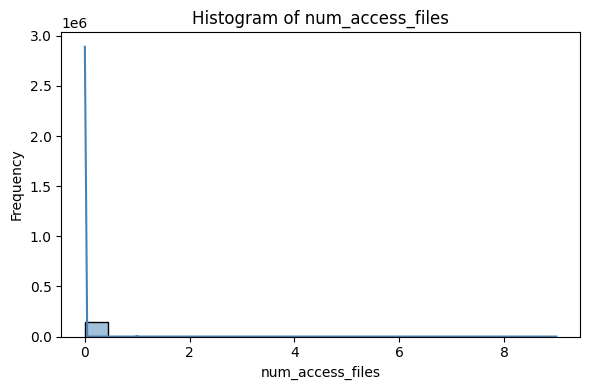

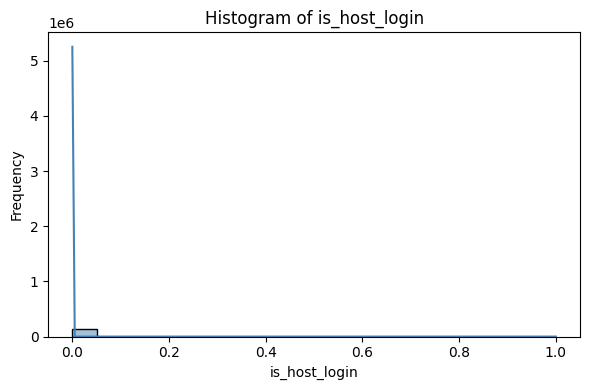

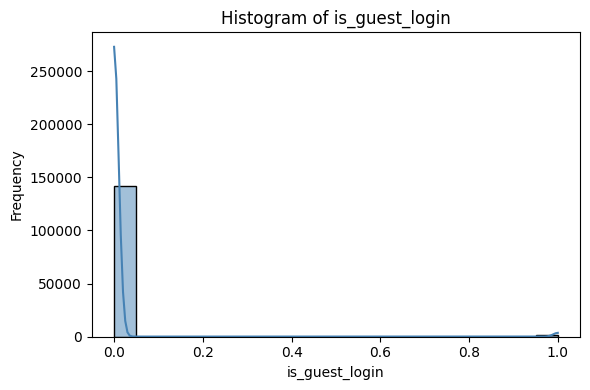

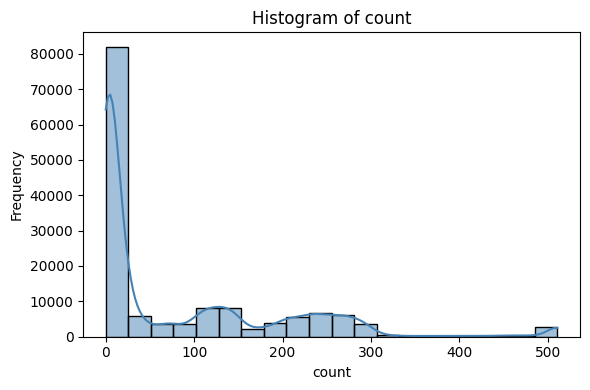

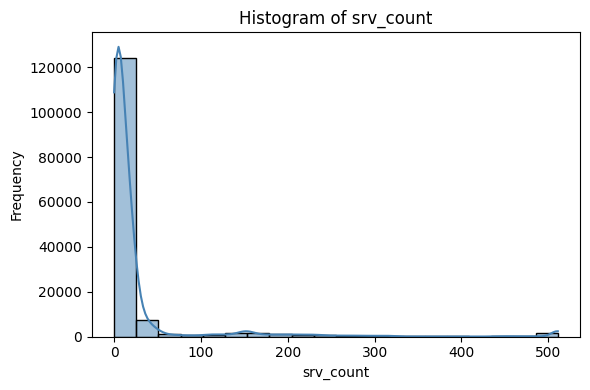

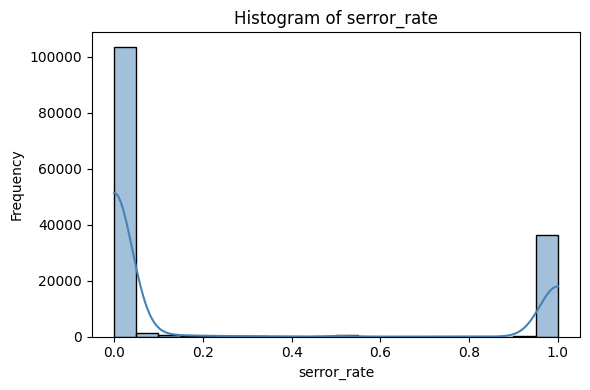

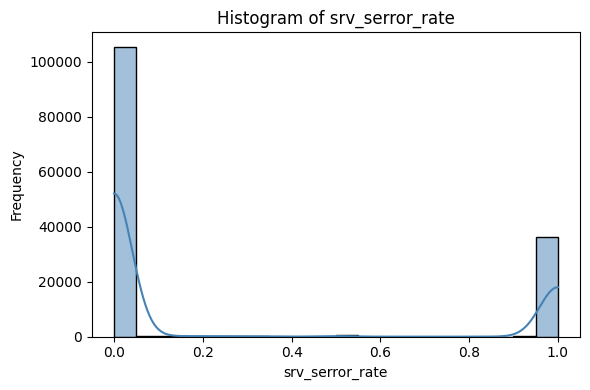

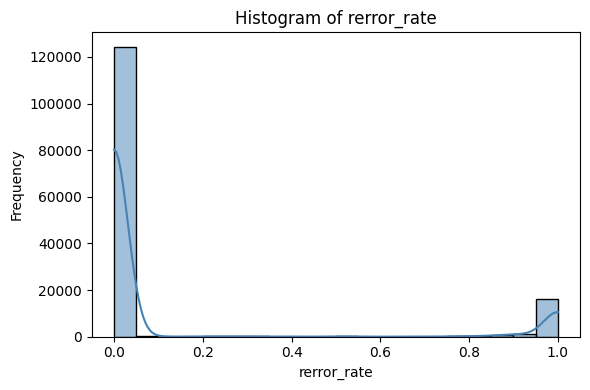

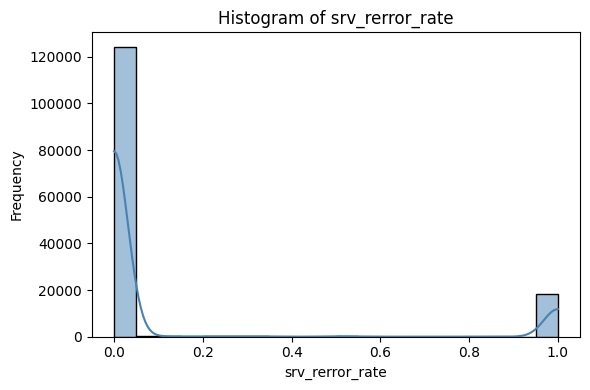

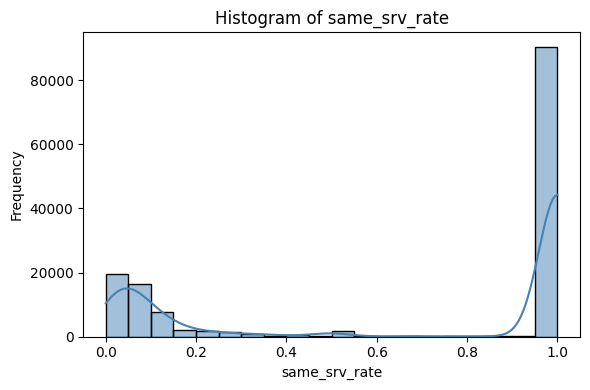

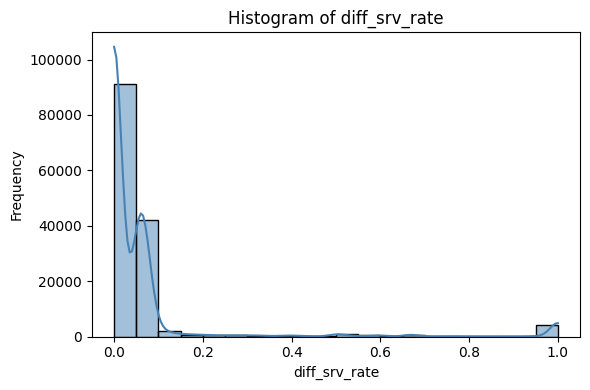

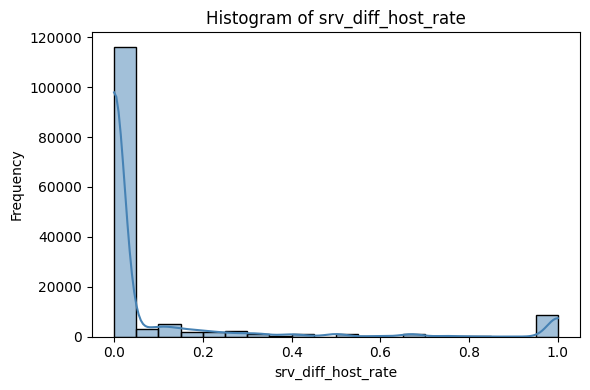

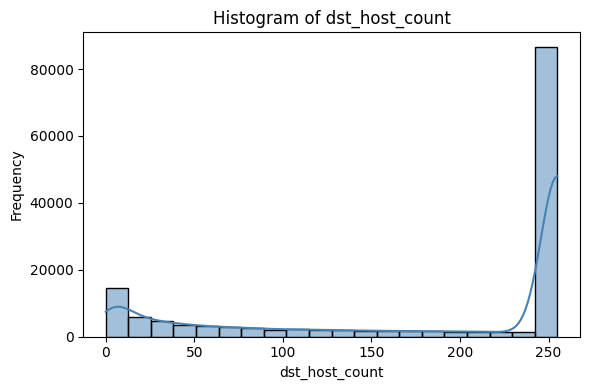

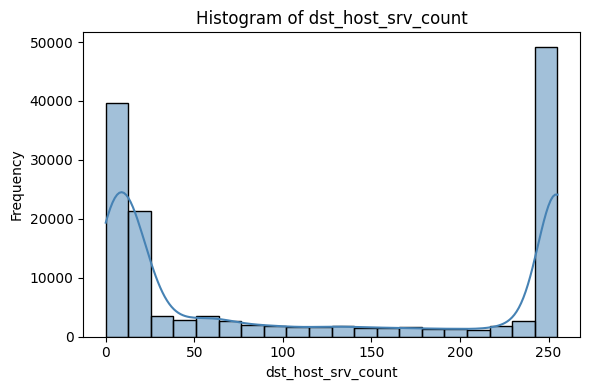

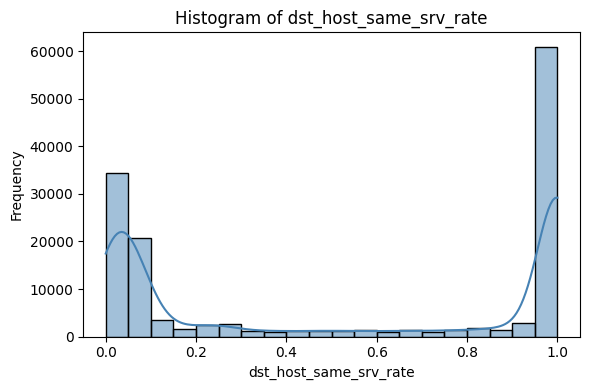

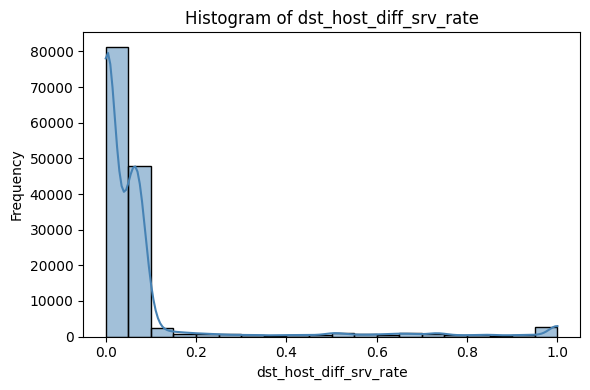

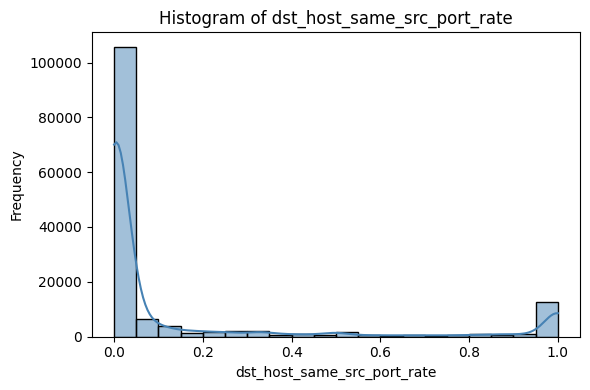

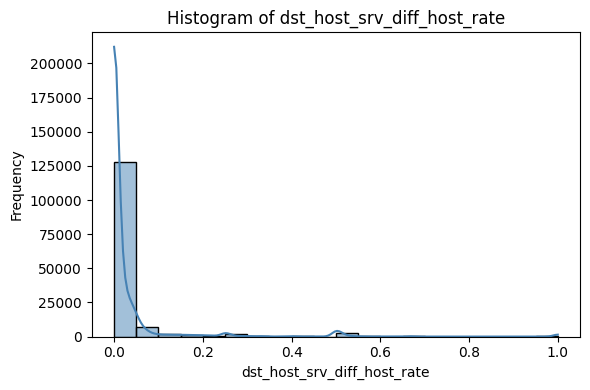

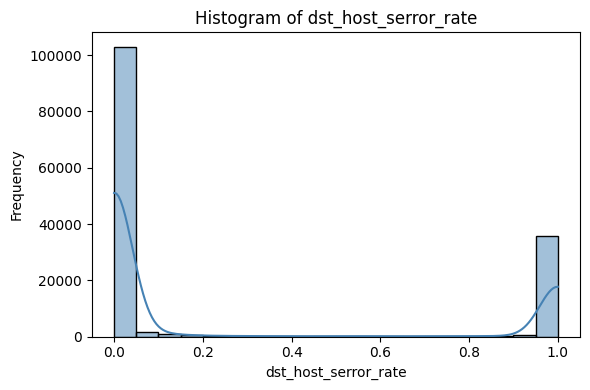

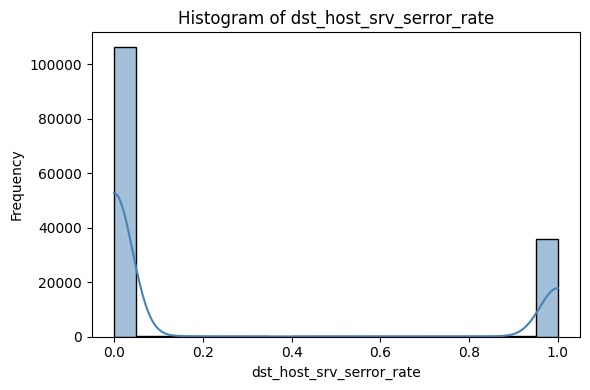

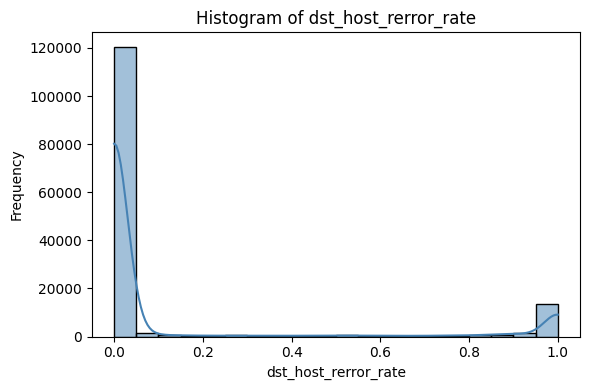

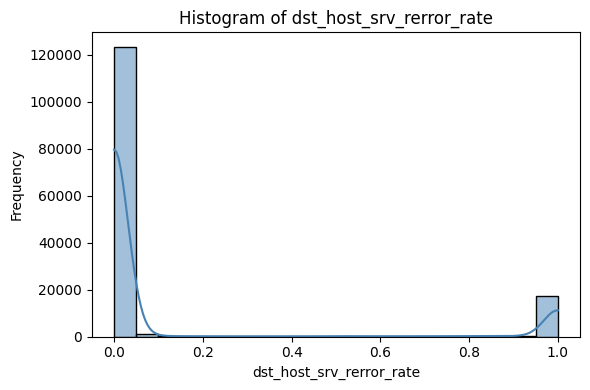

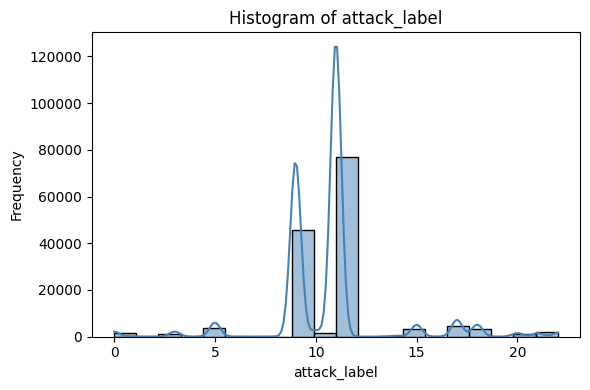

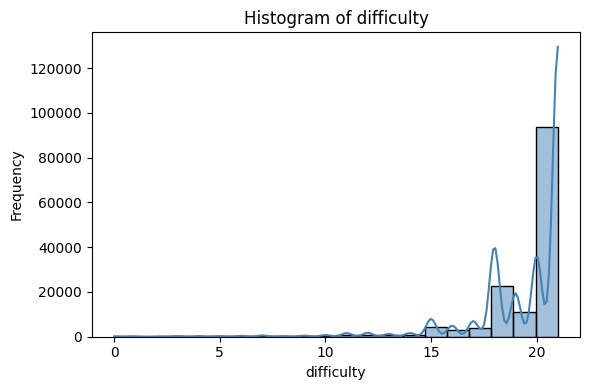

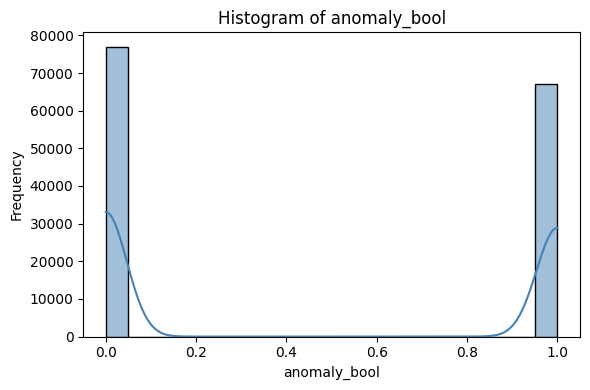

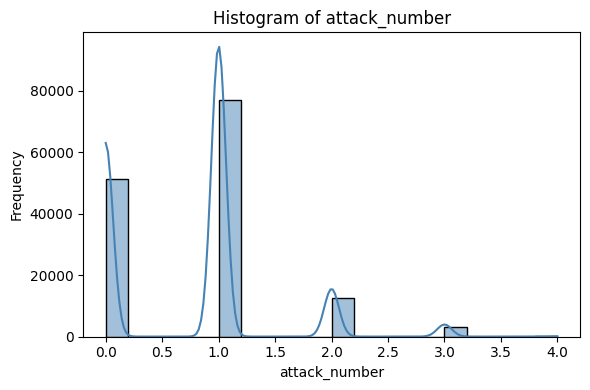

In [32]:
# Inspect histograms for all features to understand distributions
data.inspect_histograms(df = data.df)

In [33]:
# Inspect outliers overall and grouped by the preferred target column: attack_category
overall_stats, group_stats = data.inspect_outliers(
    df=data.df,
    iqr_mult=1.5,
    sort_by="percentage",
    ascending=False,
    top_n=None,
    group_by="attack_category",
    return_group_stats=True,
)


=== Outlier statistics (IQR method, mult=1.5) ===
                             Outlier Count  Outlier Percentage
srv_diff_host_rate                   32333               22.43
dst_host_rerror_rate                 28931               20.07
dst_host_same_src_port_rate          28146               19.52
protocol_type                        25919               17.98
dst_bytes                            25341               17.58
dst_host_srv_rerror_rate             24033               16.67
rerror_rate                          20095               13.94
srv_rerror_rate                      20020               13.89
attack_label                         19618               13.61
src_bytes                            15538               10.78
srv_count                            14387                9.98
dst_host_srv_diff_host_rate          12690                8.80
dst_host_diff_srv_rate               12054                8.36
duration                             11966                8.30
diff

The feature histograms and the outlier analysis give us important clues about which scaling method is appropriate. We observe the following characteristics:

- features with very different scales
- a large number of outliers
- many values clustered near or around zero
- a generally large dataset

These observations suggest that StandardScaler is the most suitable choice.
For instance, using a MinMaxScaler on features with extremely different scales would compress most values into a very narrow range, causing the model to lose useful variation.
Likewise, applying a normalization method would make the data heavily influenced by individual outliers, since each sample would be scaled independently.

Therefore, StandardScaler provides a more stable and meaningful transformation for this dataset.

In [34]:
# Inspect distribution of preferred target column
attack_stats = data.inspect_column(
    column="attack_category",
    df=data.df,
    dropna=False,
    top_n=None,
    print_result=True,
)


=== Column inspection: 'attack_category' ===
                 Count  Percentage
attack_category                   
normal           76967       53.39
dos              51268       35.56
probe            12639        8.77
r2l               3194        2.22
u2r                 89        0.06


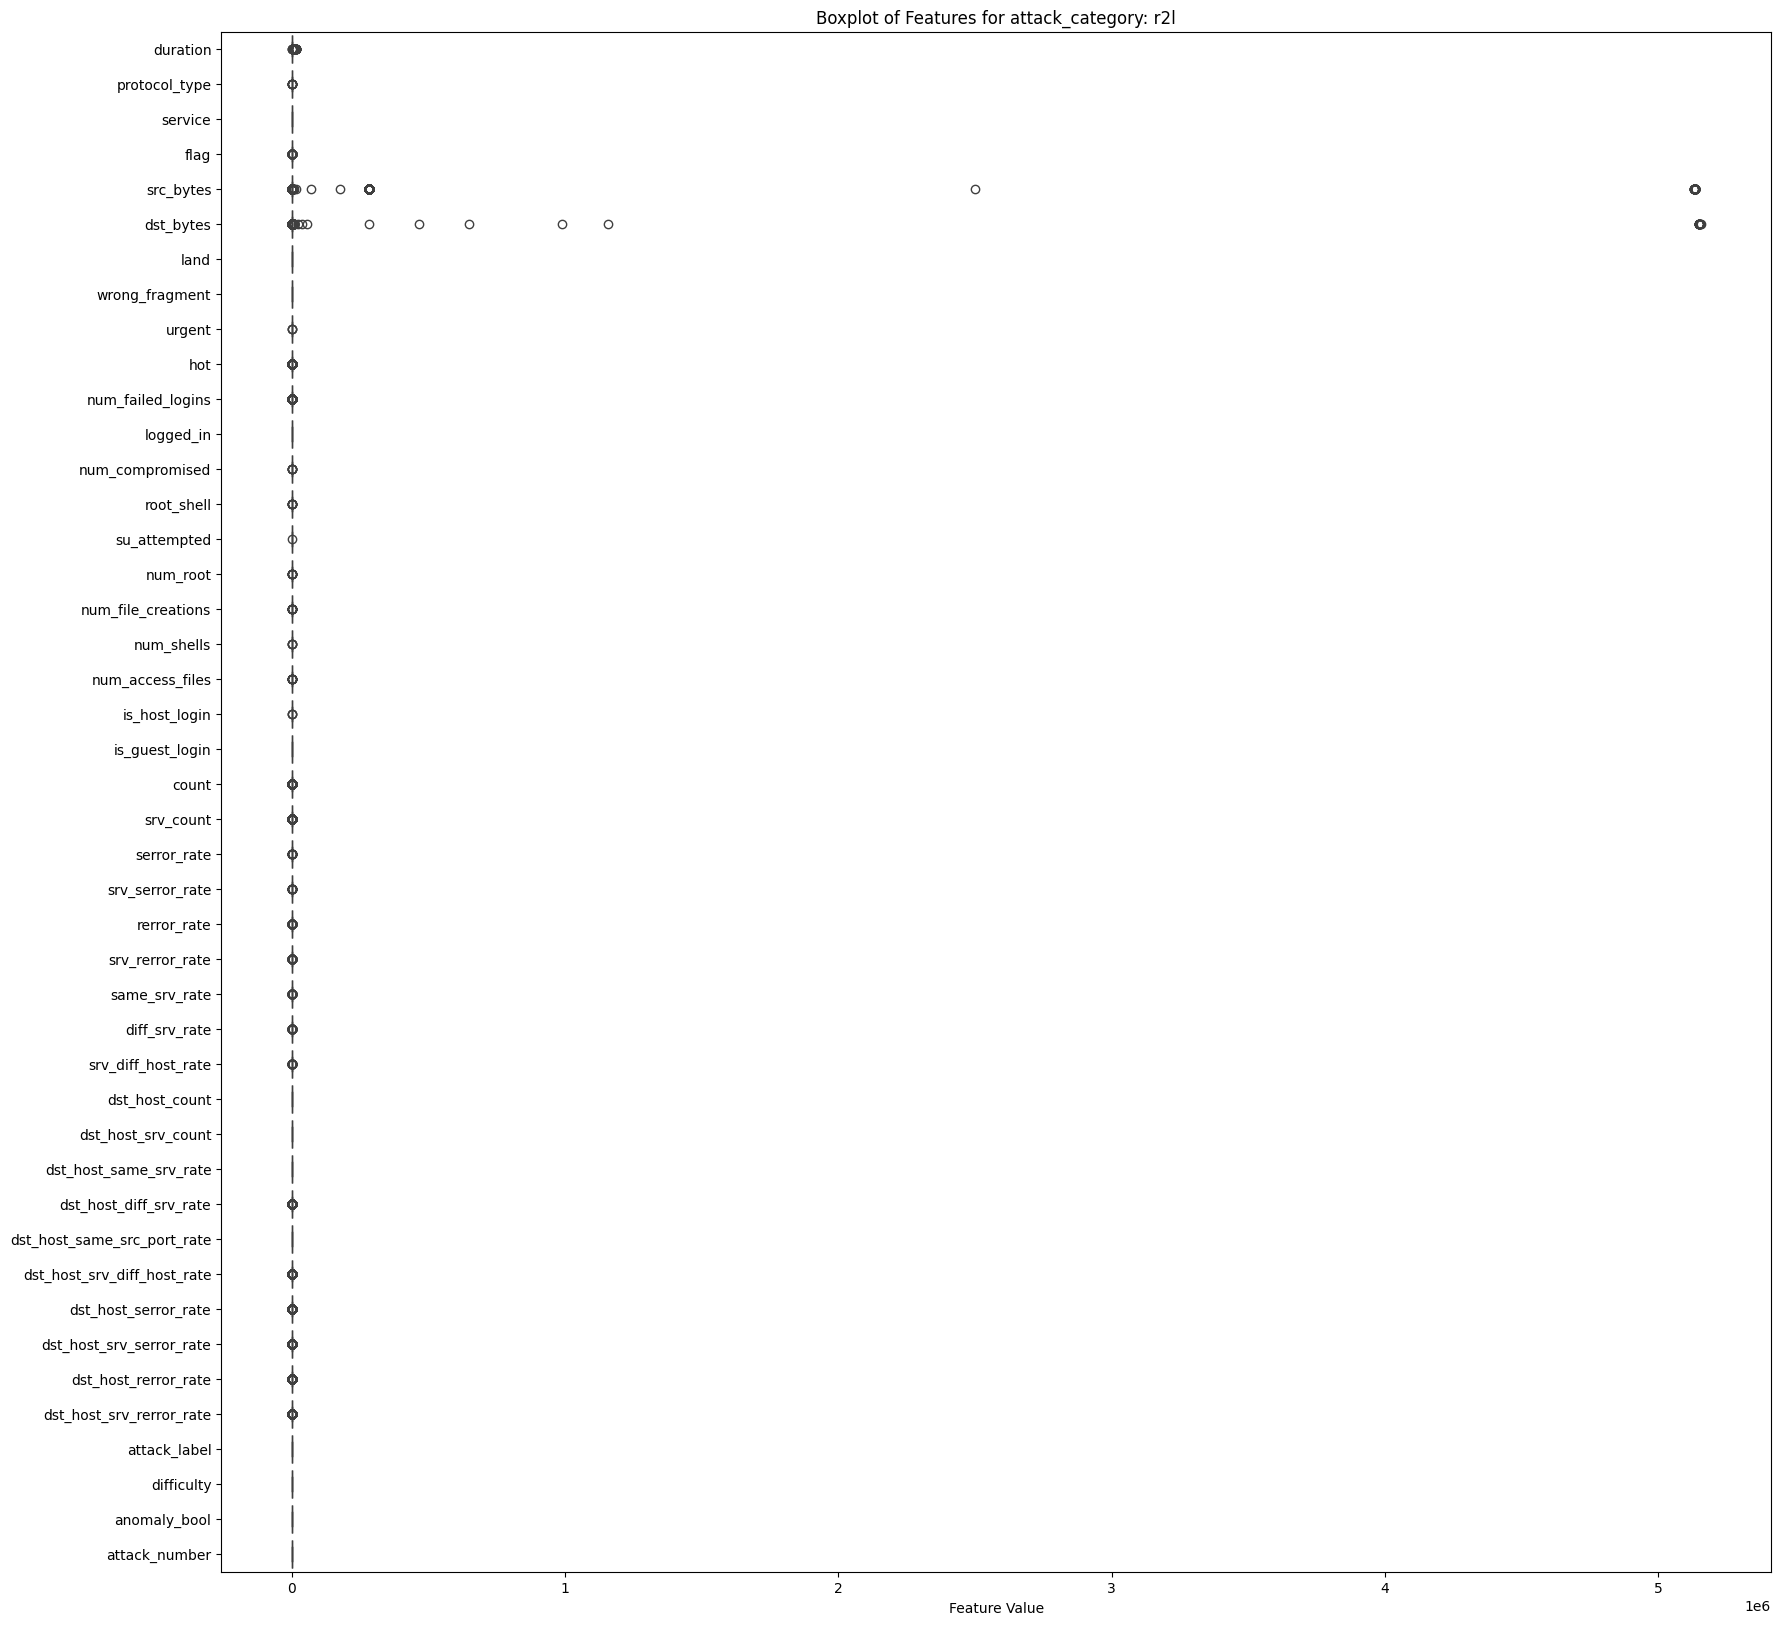

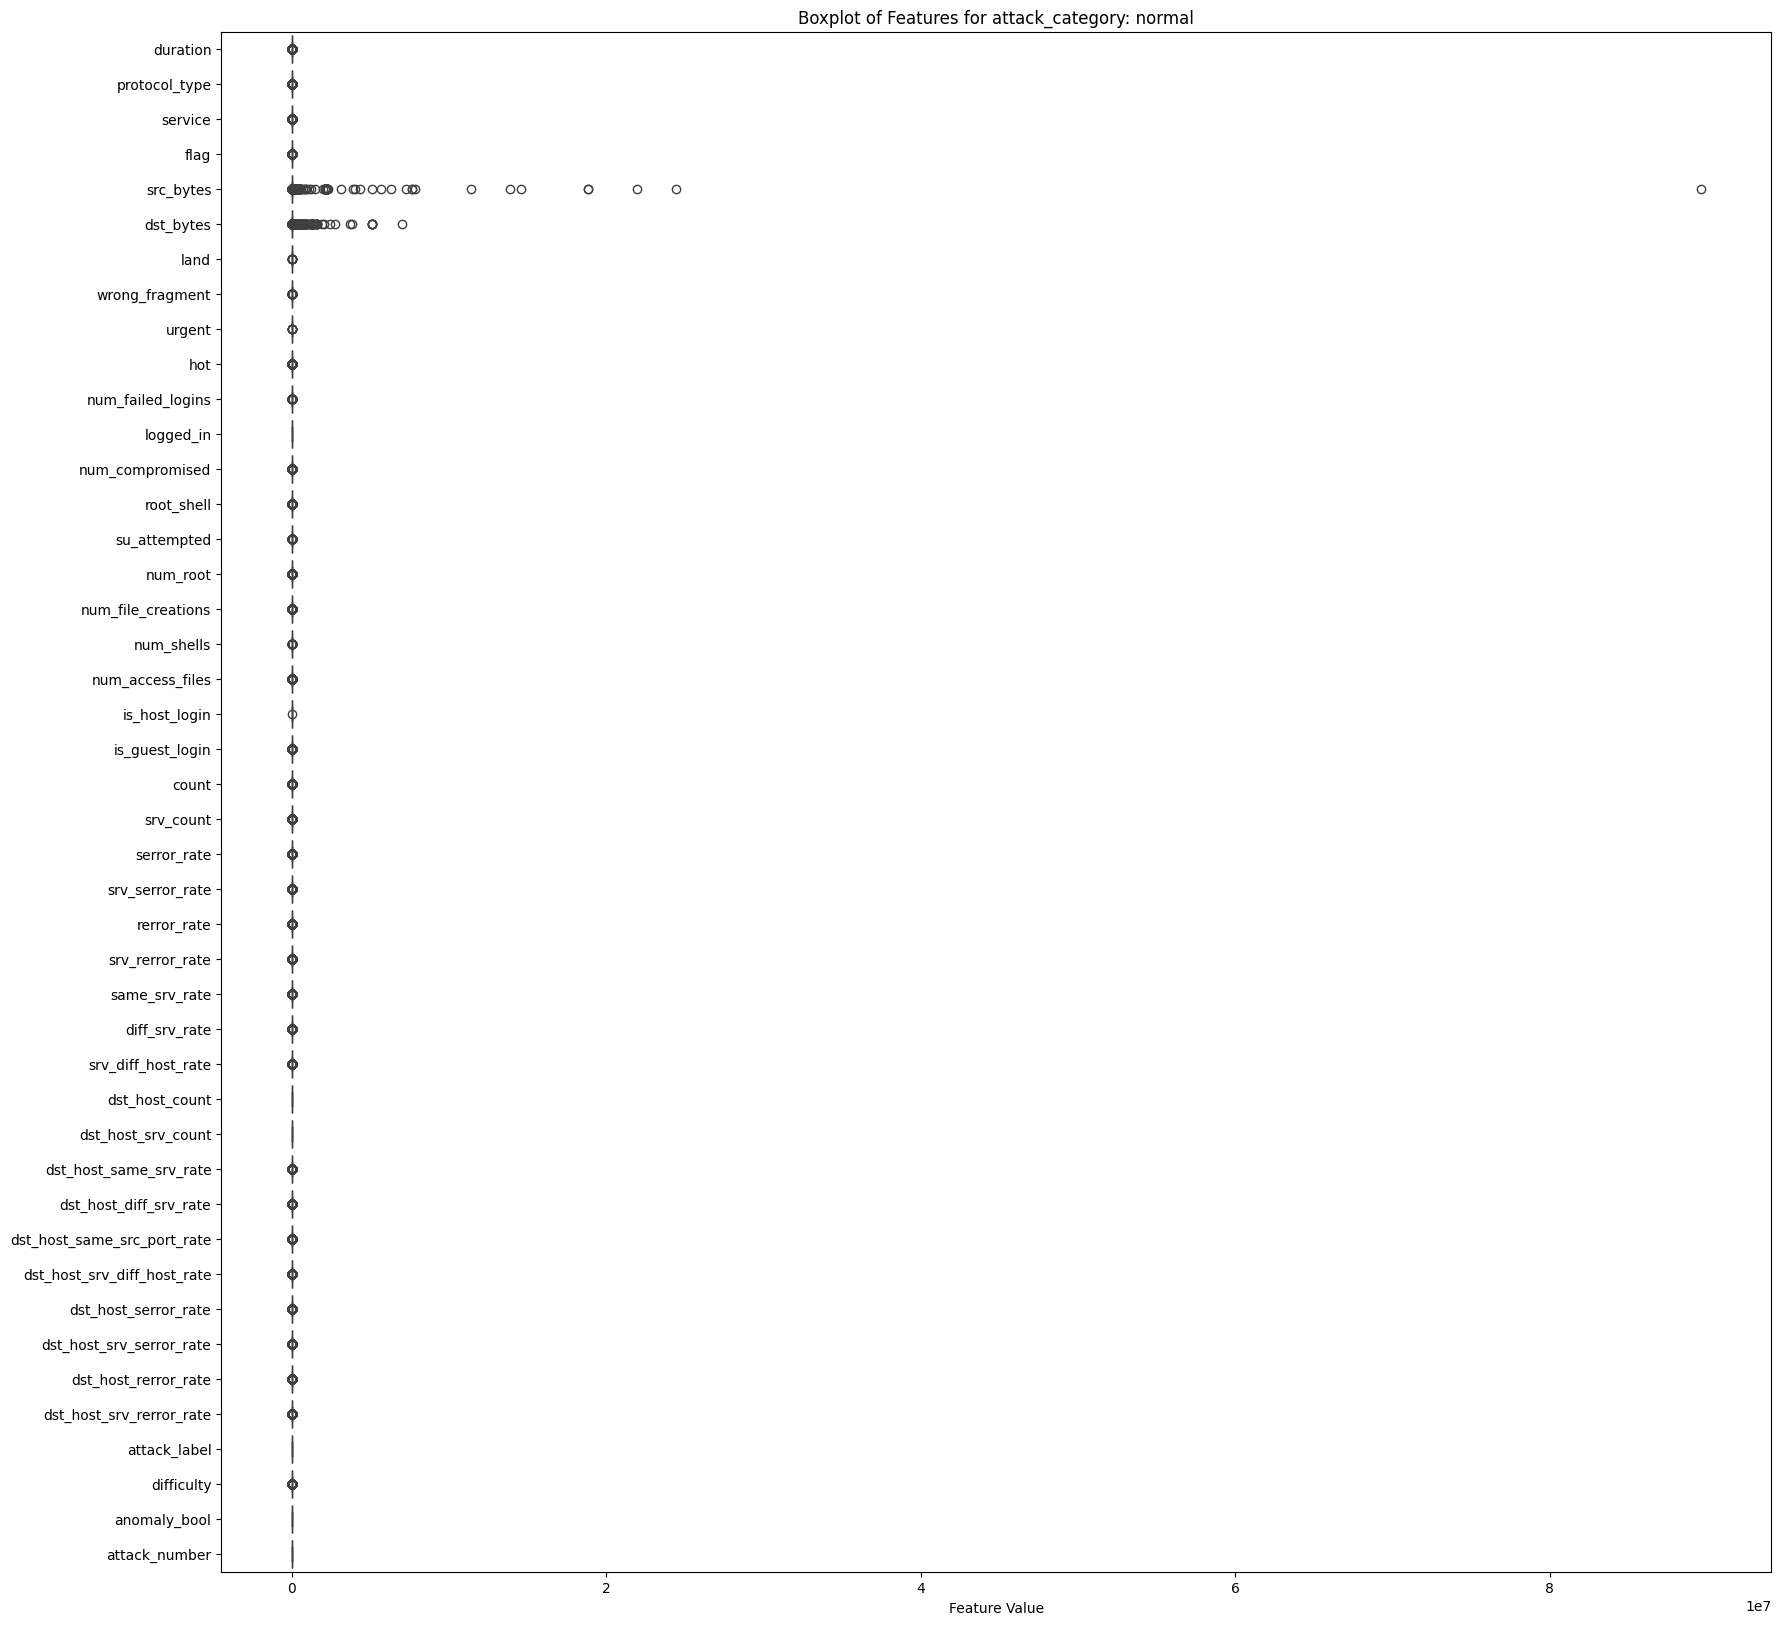

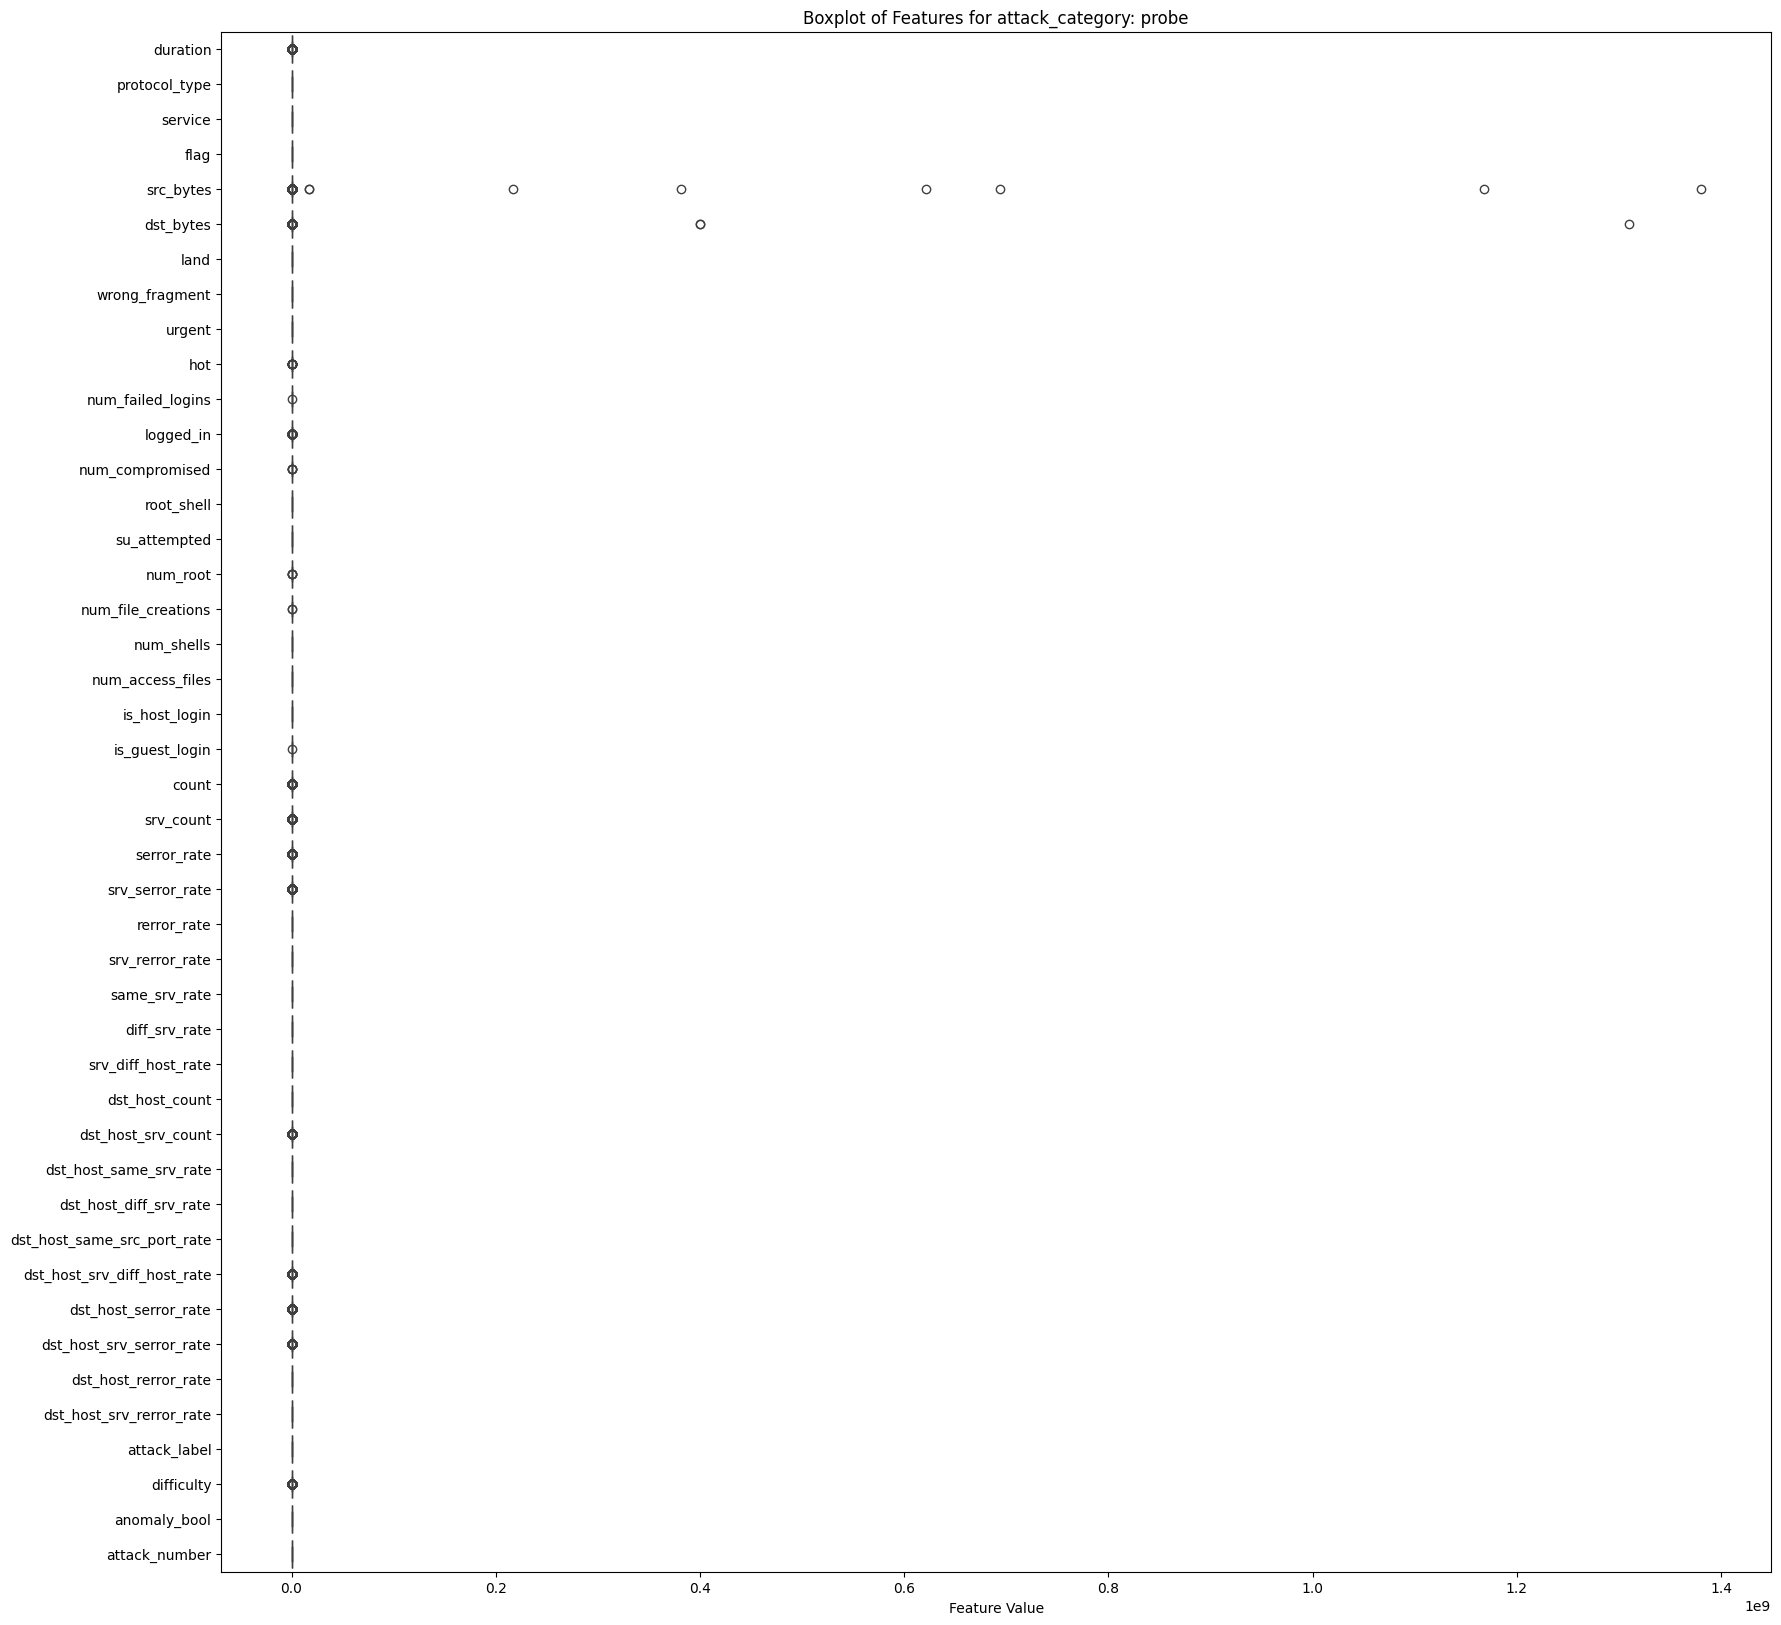

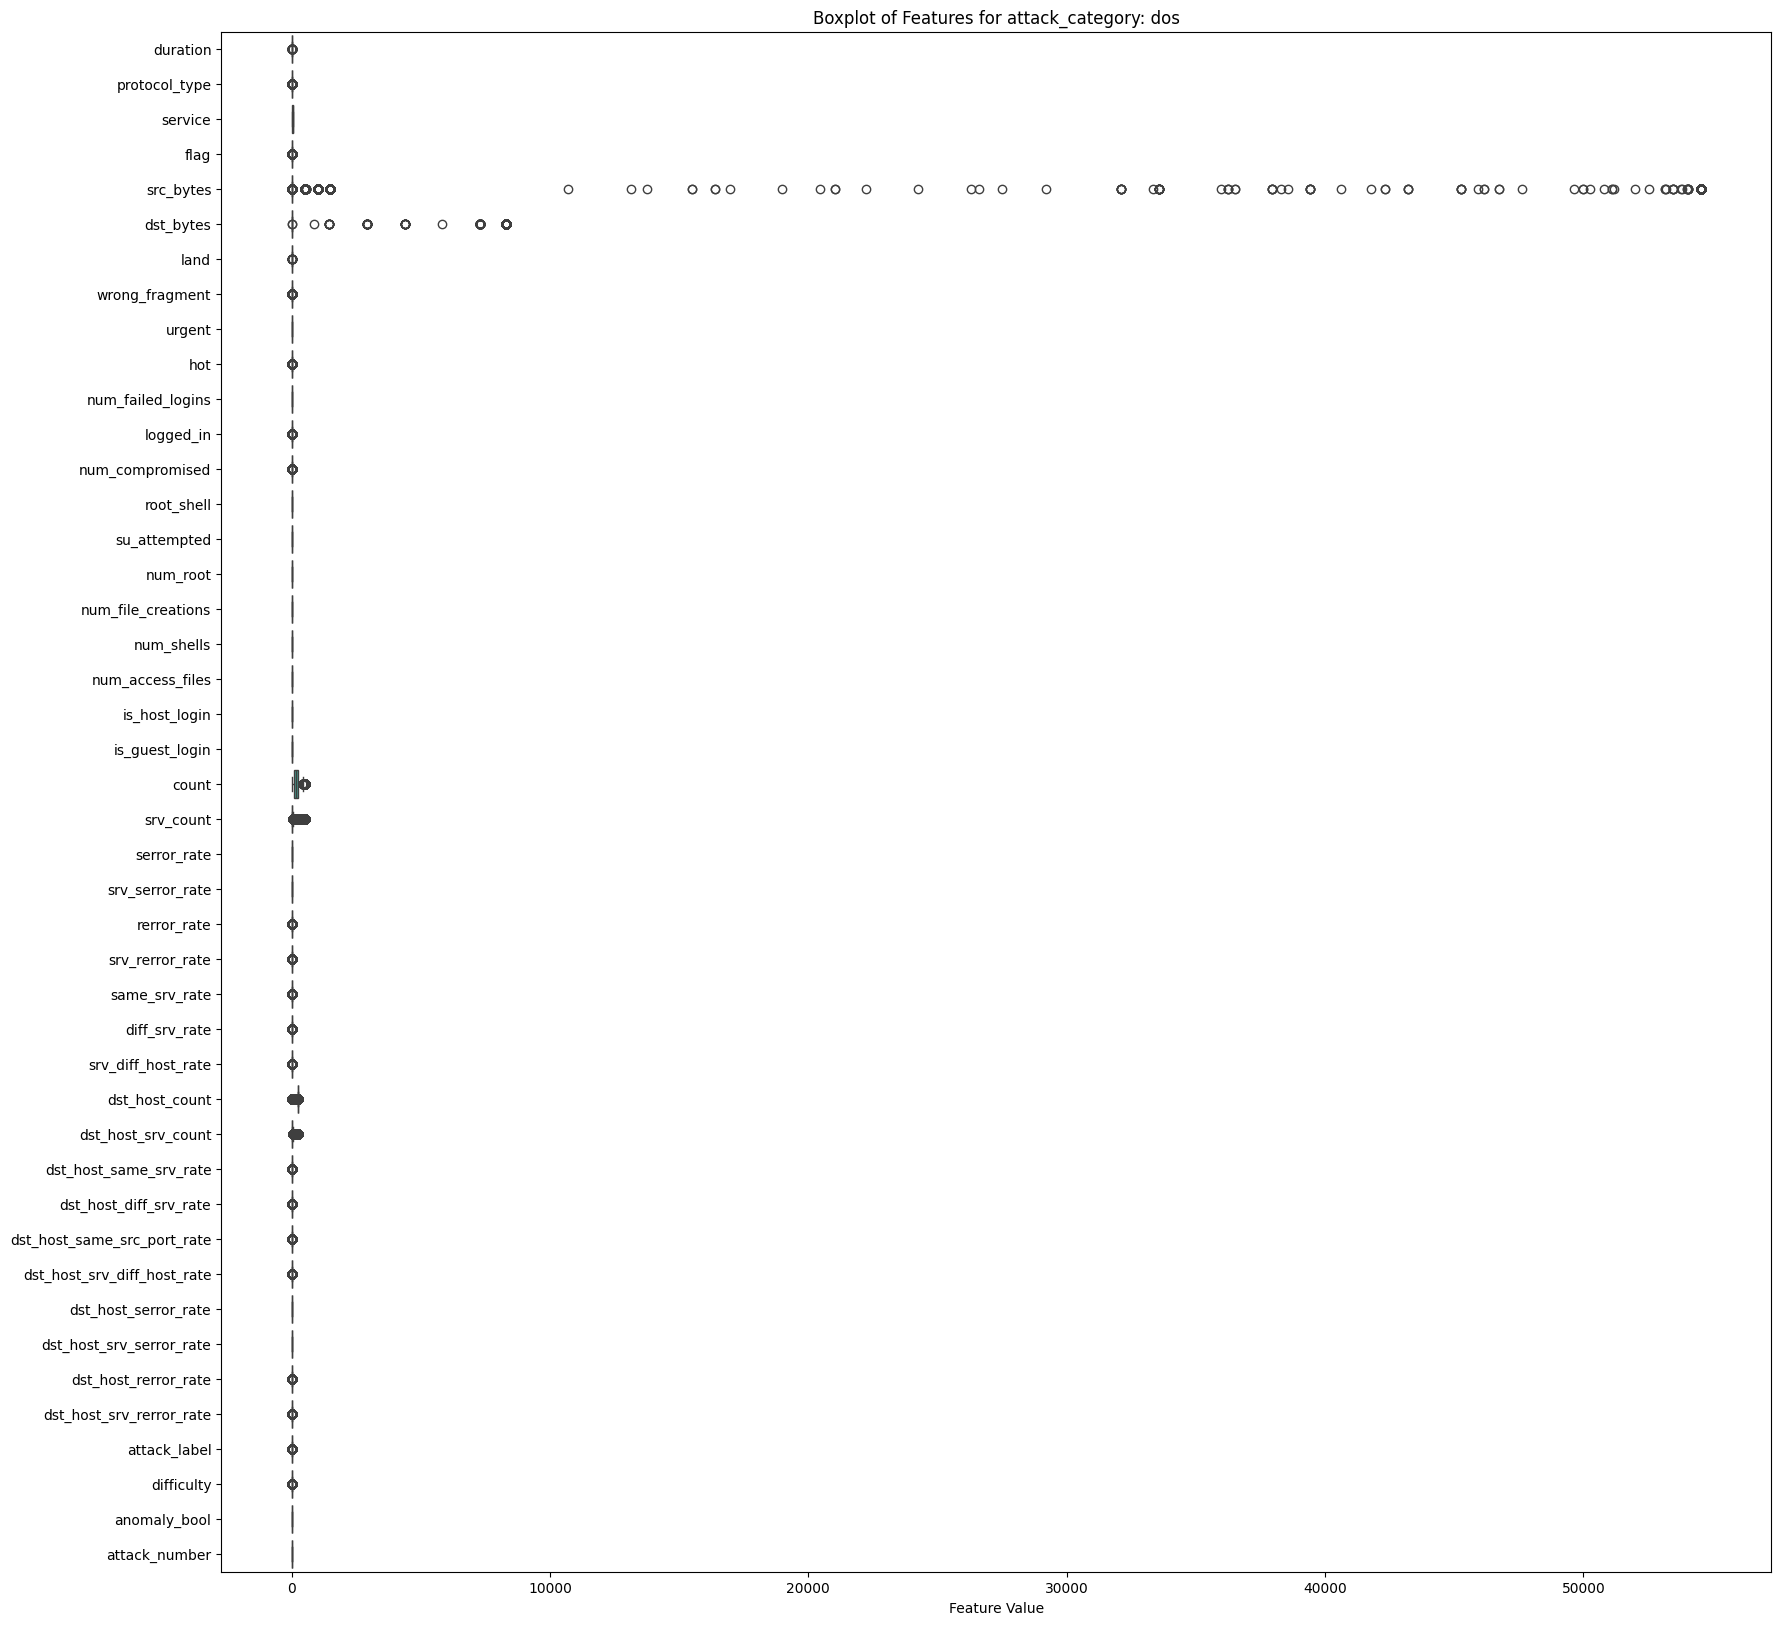

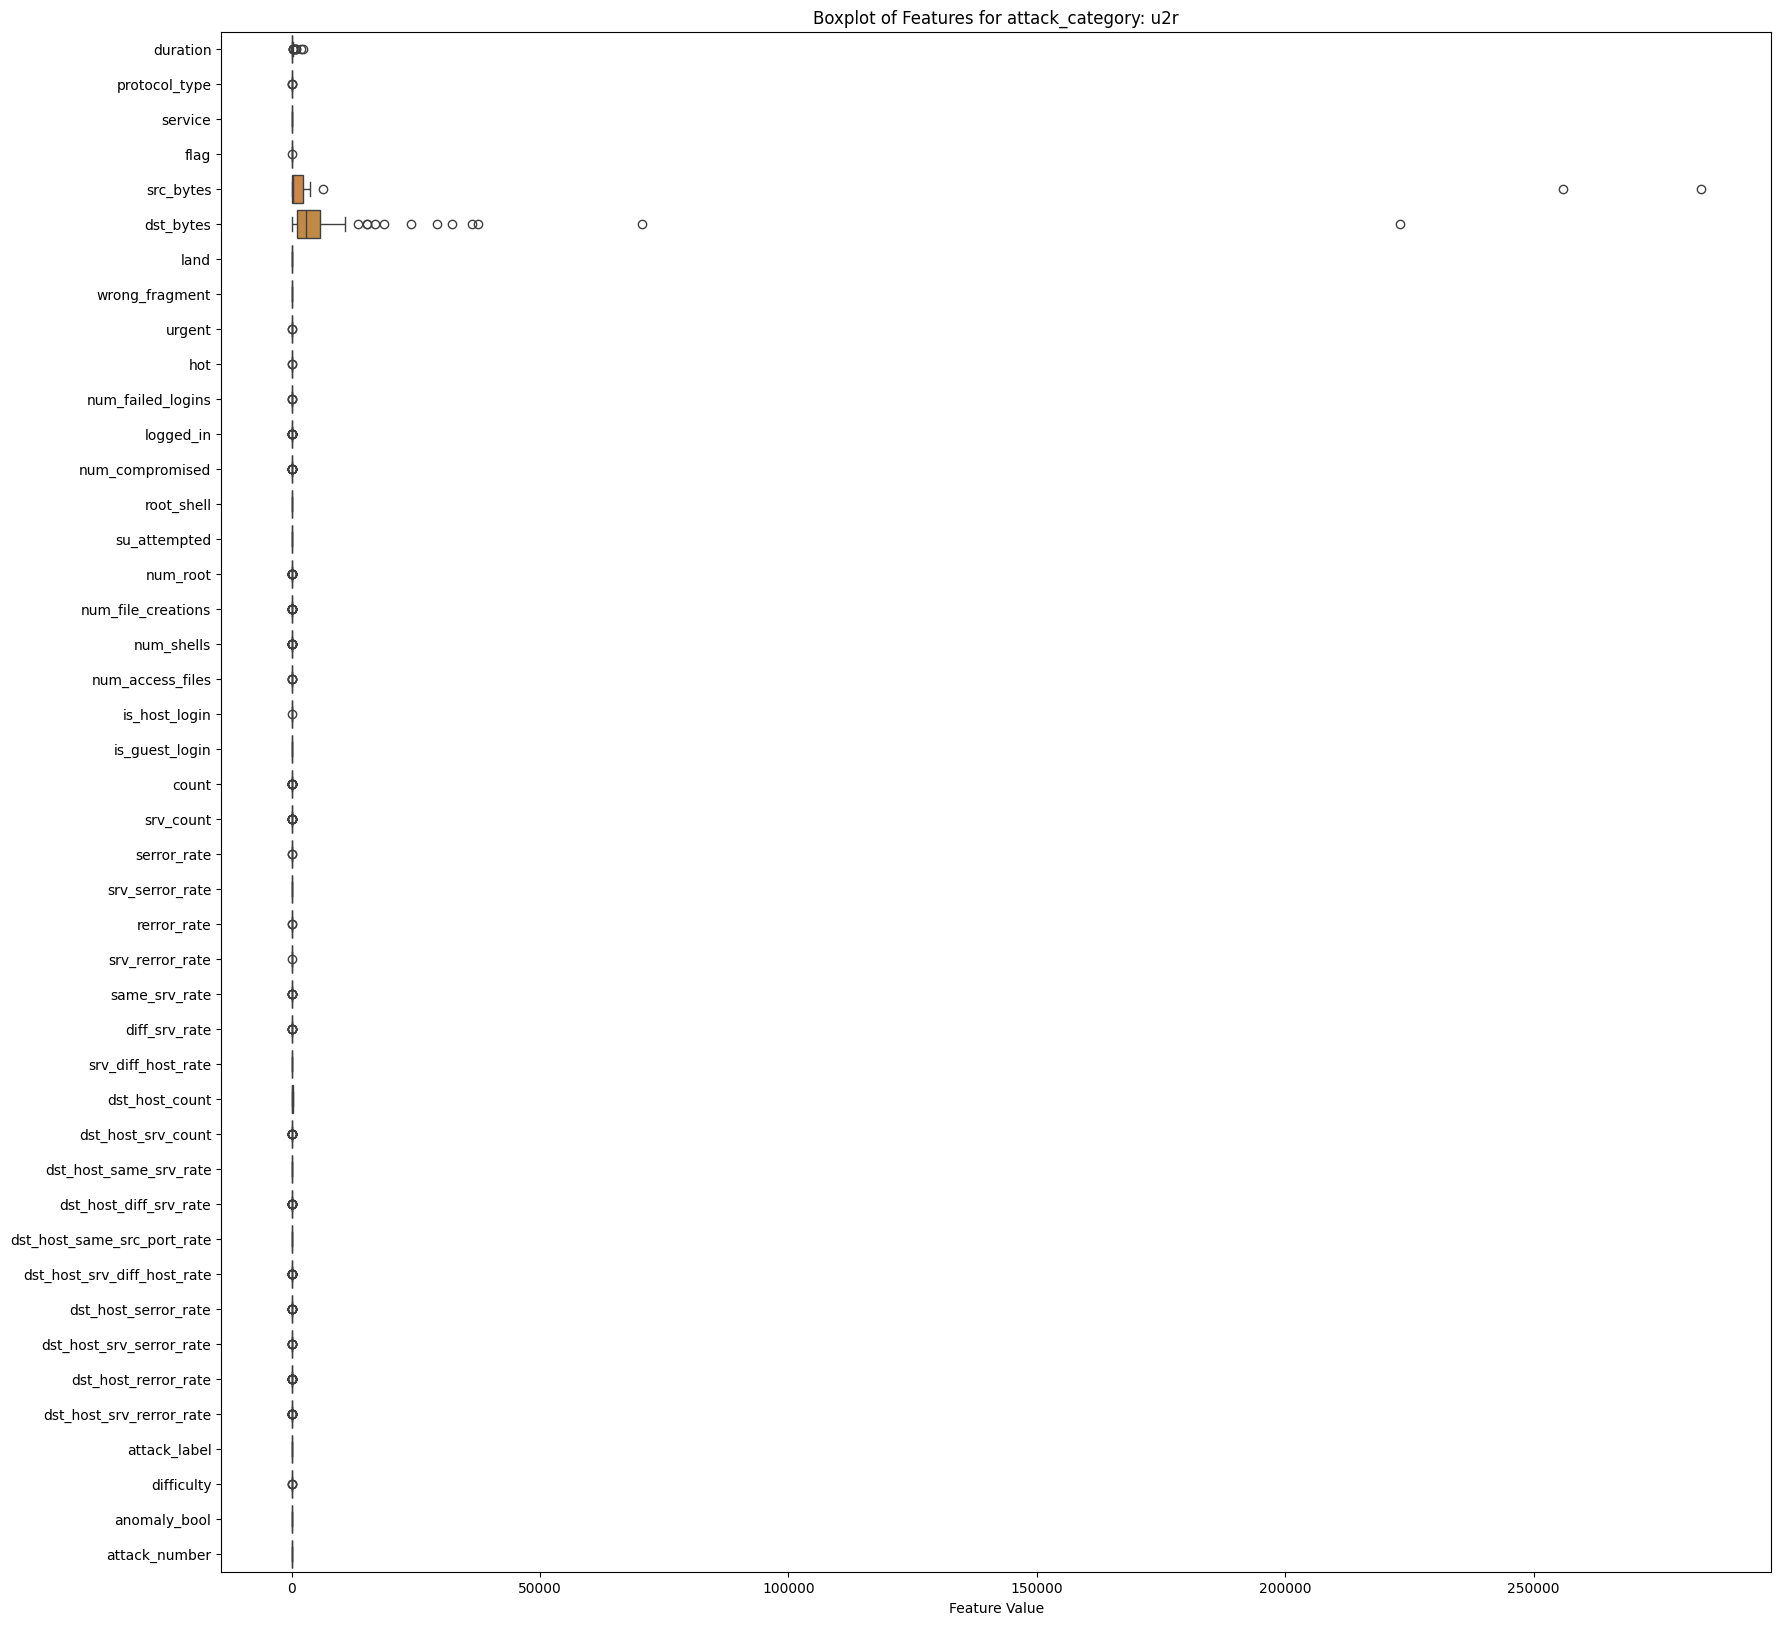

In [35]:
# Show which features are most important for each attack_category
for attack_category in data.df['attack_category'].unique():
    attack_data = data.df[data.df['attack_category'] == attack_category]
    plt.figure(figsize=(20, 20))
    sns.boxplot(data = attack_data.drop(columns = ['attack_category']), orient = 'h')
    plt.title(f'Boxplot of Features for attack_category: {attack_category}')
    plt.xlabel('Feature Value')
    plt.show()



The charts above do not directly determine how the data should be preprocessed. However, they play an important role in the later modelling steps, as they reveal which features may be particularly relevant for distinguishing certain attack types. This insight helps guide feature selection and supports a more targeted model development process.

Features may be important for distinguishing attack types if:

- they show distinct median shifts across different attack categories
- they exhibit clearly separated interquartile ranges between classes
- they contain class-specific outliers that indicate unique behavioural patterns
- they show reduced overlap between boxplot distributions of different attack types
- they display consistent variance differences that correlate with certain attack classes

In [36]:
data.inspect()


=== NSL-KDD Combined Dataset: SHAPE ===
(144157, 45)

=== NSL-KDD Combined Dataset: HEAD ===
   duration  protocol_type  service  flag  src_bytes  dst_bytes  land  \
0        13              1       60     9        118       2425     0   
3         0              2       49     9         53         55     0   
4         0              1       49    10          0          0     0   
5         0              1       24     9      54540       8314     0   
6         0              1       28     1          0          0     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_diff_host_rate  \
0               0       0    0  ...                          0.0   
3               0       0    0  ...                          0.0   
4               0       0    0  ...                          0.0   
5               0       0    2  ...                          0.0   
6               0       0    0  ...                          0.0   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_hos

,count,mean,std,min,25%,50%,75%,max
duration,144157.0,255.593970,2.455803e+03,0.0,0.00,0.00,0.00,5.445100e+04
protocol_type,144157.0,1.056265,4.202767e-01,0.0,1.00,1.00,1.00,2.000000e+00
service,144157.0,31.426986,1.618830e+01,0.0,20.00,24.00,49.00,6.900000e+01
flag,144157.0,6.993486,2.754100e+00,0.0,5.00,9.00,9.00,1.000000e+01
src_bytes,144157.0,40560.318923,5.487682e+06,0.0,0.00,45.00,278.00,1.379964e+09
dst_bytes,144157.0,17592.985648,3.759113e+06,0.0,0.00,0.00,607.00,1.309937e+09
land,144157.0,0.000201,1.418205e-02,0.0,0.00,0.00,0.00,1.000000e+00
wrong_fragment,144157.0,0.020963,2.431196e-01,0.0,0.00,0.00,0.00,3.000000e+00
urgent,144157.0,0.000125,1.580234e-02,0.0,0.00,0.00,0.00,3.000000e+00
hot,144157.0,0.194586,2.042863e+00,0.0,0.00,0.00,0.00,1.010000e+02


In [37]:
data.df.to_csv("../output/EDA.csv", index=False)

At this stage, the exploratory data analysis is complete, and we store the current dataset as a checkpoint. This version will serve as the foundation for the subsequent preprocessing steps.